In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid

### Bloque 3: Preparar el dataset MNIST

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Rango [-1, 1]
])

mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(mnist, batch_size=128, shuffle=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 489kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.86MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 3.43MB/s]


### Bloque 4: Definir el Generador y Discriminador

In [3]:
class Generator(nn.Module):
    def __init__(self, noise_dim=100):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 784),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z).view(-1, 1, 28, 28)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

### Bloque 5: Inicializar modelos, pérdidas y optimizadores

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

G = Generator().to(device)
D = Discriminator().to(device)

loss_fn = nn.BCELoss()
opt_G = optim.Adam(G.parameters(), lr=0.0002)
opt_D = optim.Adam(D.parameters(), lr=0.0002)

fixed_noise = torch.randn(64, 100).to(device)  # Ruido fijo para ver progreso

### Bloque 6: Entrenamiento de la GAN

In [5]:
epochs = 30
G_losses, D_losses = [], []

for epoch in range(epochs):
    for real_imgs, _ in dataloader:
        batch_size = real_imgs.size(0)
        real_imgs = real_imgs.to(device)

        # ==== Entrenar Discriminador ====
        z = torch.randn(batch_size, 100).to(device)
        fake_imgs = G(z)

        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        D_real = D(real_imgs)
        D_fake = D(fake_imgs.detach())

        loss_D_real = loss_fn(D_real, real_labels)
        loss_D_fake = loss_fn(D_fake, fake_labels)
        loss_D = loss_D_real + loss_D_fake

        opt_D.zero_grad()
        loss_D.backward()
        opt_D.step()

        # ==== Entrenar Generador ====
        D_fake = D(fake_imgs)
        loss_G = loss_fn(D_fake, real_labels)  # Quiere que D piense que son reales

        opt_G.zero_grad()
        loss_G.backward()
        opt_G.step()

    # Guardar métricas por época
    G_losses.append(loss_G.item())
    D_losses.append(loss_D.item())

    print(f"Época [{epoch+1}/{epochs}]  Pérdida D: {loss_D.item():.4f}  Pérdida G: {loss_G.item():.4f}")

Época [1/30]  Pérdida D: 0.0520  Pérdida G: 4.6508
Época [2/30]  Pérdida D: 0.3233  Pérdida G: 3.4622
Época [3/30]  Pérdida D: 1.3423  Pérdida G: 1.6838
Época [4/30]  Pérdida D: 1.3172  Pérdida G: 0.9160
Época [5/30]  Pérdida D: 1.3410  Pérdida G: 0.9176
Época [6/30]  Pérdida D: 0.7472  Pérdida G: 2.0634
Época [7/30]  Pérdida D: 0.8483  Pérdida G: 2.2952
Época [8/30]  Pérdida D: 0.5658  Pérdida G: 2.2568
Época [9/30]  Pérdida D: 0.4561  Pérdida G: 3.2678
Época [10/30]  Pérdida D: 0.3215  Pérdida G: 2.6761
Época [11/30]  Pérdida D: 0.9884  Pérdida G: 2.6162
Época [12/30]  Pérdida D: 0.7200  Pérdida G: 2.1559
Época [13/30]  Pérdida D: 0.3349  Pérdida G: 3.3479
Época [14/30]  Pérdida D: 0.5240  Pérdida G: 2.1020
Época [15/30]  Pérdida D: 0.8412  Pérdida G: 2.0708
Época [16/30]  Pérdida D: 0.4843  Pérdida G: 2.8583
Época [17/30]  Pérdida D: 0.7239  Pérdida G: 3.1779
Época [18/30]  Pérdida D: 0.6801  Pérdida G: 2.7836
Época [19/30]  Pérdida D: 0.7713  Pérdida G: 2.9476
Época [20/30]  Pérdid

### Bloque 7: Visualizar progreso del generador

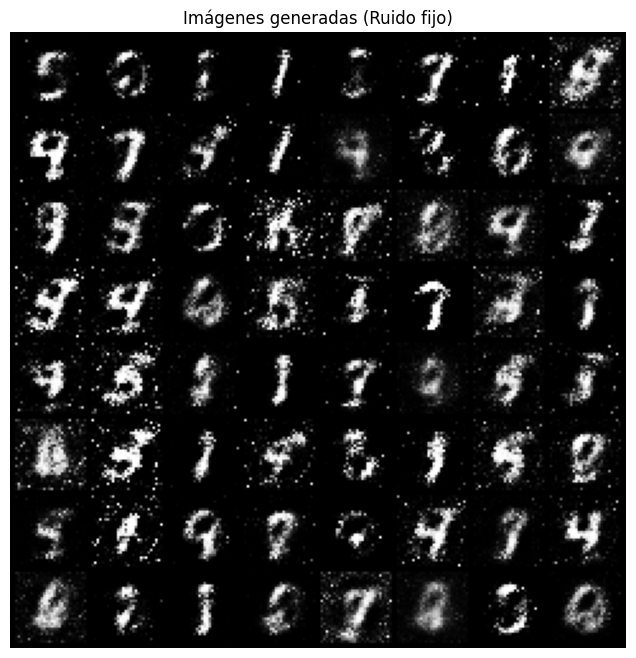

In [6]:
G.eval()
with torch.no_grad():
    generated = G(fixed_noise).cpu()
G.train()

grid = make_grid(generated, nrow=8, normalize=True)
plt.figure(figsize=(8, 8))
plt.imshow(np.transpose(grid, (1, 2, 0)))
plt.title("Imágenes generadas (Ruido fijo)")
plt.axis("off")
plt.show()

### Bloque 8: Visualizar curvas de pérdida

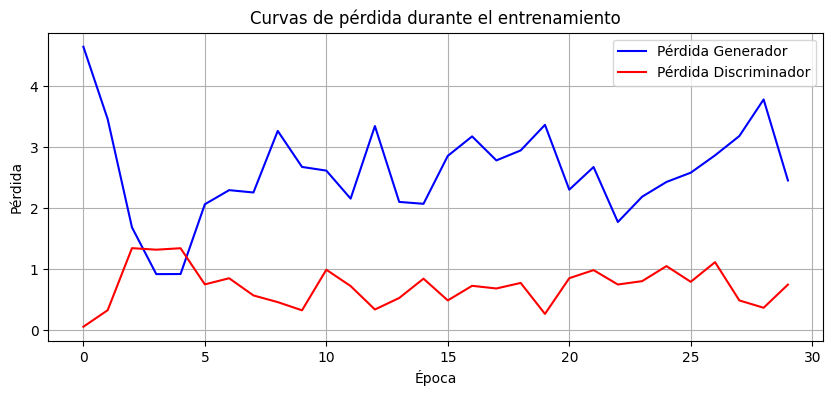

In [7]:
plt.figure(figsize=(10, 4))
plt.plot(G_losses, label="Pérdida Generador", color="blue")
plt.plot(D_losses, label="Pérdida Discriminador", color="red")
plt.xlabel("Época")
plt.ylabel("Pérdida")
plt.legend()
plt.grid(True)
plt.title("Curvas de pérdida durante el entrenamiento")
plt.show()

### Bloque para generar animación en Colab

In [14]:
import torch
import os
import imageio
from torchvision.utils import save_image

# Asegúrate de que G esté definido y entrenado previamente
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.makedirs("gan_frames", exist_ok=True)

# Generar 20 conjuntos de imágenes para ver progresión
for epoch in range(20):
    with torch.no_grad():
        z = torch.randn(64, 100).to(device)
        fake_imgs = G(z).cpu()
        save_image(fake_imgs, f"gan_frames/frame_{epoch:03d}.png", nrow=8, normalize=True)

# Crear GIF
images = [imageio.imread(f"gan_frames/frame_{epoch:03d}.png") for epoch in range(20)]
imageio.mimsave("gan_progress.gif", images, fps=3)

/tmp/ipython-input-14-3499166903.py:18: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [imageio.imread(f"gan_frames/frame_{epoch:03d}.png") for epoch in range(20)]


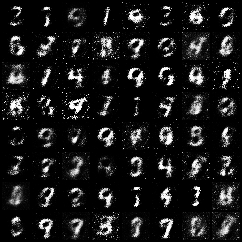

In [15]:
from IPython.display import Image
Image(filename="gan_progress.gif")